# Generalised Linear Model for bionomial distribution

This model in prototyped with TensorFlow Probability and inferecne is performed with variational Bayes by stochastic gradient descent. 

Author: Yuanhua Huang

Date: 16/12/2019

### The model

$$X = G \times \theta \times W$$
$$P(a_i|d_i, x_i) = x_{i}^{(a_i)}(1-x_i)^{(d_i-a_i)}$$
$$\log\mathcal{L}(W) = \log(P(A|D, W)) = \prod_{i=1}^{N} \{(a_i)\log(x_{i}) + (d_i-a_i)\log(1-x_i)\}$$

where $X$ is a vector of $N$ allelic ratio and $G$ is $(N, K, 3)$ for $K$ donors and 3 genotype categories. $W$ is the proportional weights for each of the $K$ donors.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

### Simulation

In [2]:
import numpy as np

# Settings
np.random.seed(2)

K = 4   #number of dimensions
N = 200 #number of datapoints to generate

# Generate data
theta_true = [0.01, 0.5, 0.99]
w_true = np.random.dirichlet([1]*K)
GT = np.random.multinomial(1, [1/3, 1/3, 1/3], size=(N, K))
theta_mean = np.dot(np.dot(GT, theta_true), w_true)

D = np.random.randint(2, 25, size=(N,))
A = np.random.binomial(D, theta_mean)

In [3]:
A = tf.convert_to_tensor(A, dtype=tf.float32)
D = tf.convert_to_tensor(D, dtype=tf.float32)
GT = tf.convert_to_tensor(GT, dtype=tf.float32)

In [4]:
w_true

array([0.29096973, 0.0133462 , 0.4053198 , 0.29036427])

### Fit the binomial regression model

In [5]:
from TFBayes.GLM import BinomRegression

In [6]:
model = BinomRegression(K)

In [7]:
## random initialised weights
model.w_size

<tf.Variable 'w_size:0' shape=(4,) dtype=float32, numpy=array([0.7224884 , 0.8578299 , 0.5901126 , 0.30124712], dtype=float32)>

In [8]:
losses = model.fit(A, D, GT, num_steps=500)

In [9]:
losses.shape

TensorShape([500])

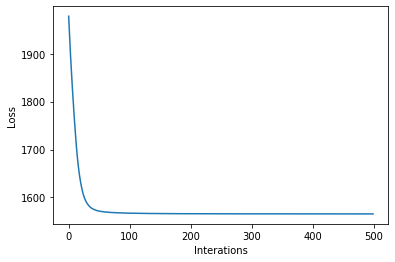

In [10]:
fig = plt.figure()
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Interations")
plt.show()

In [11]:
tf.exp(model.beta_size)

<tf.Tensor: id=3739, shape=(3, 2), dtype=float32, numpy=
array([[ 0.17206207, 17.942368  ],
       [ 2.8121333 ,  2.6831915 ],
       [13.310326  ,  0.18168078]], dtype=float32)>

In [12]:
model.weight.mean()

<tf.Tensor: id=3744, shape=(4,), dtype=float32, numpy=array([0.29982993, 0.01639715, 0.4070363 , 0.27673662], dtype=float32)>

### Plot marginalised posterior probability

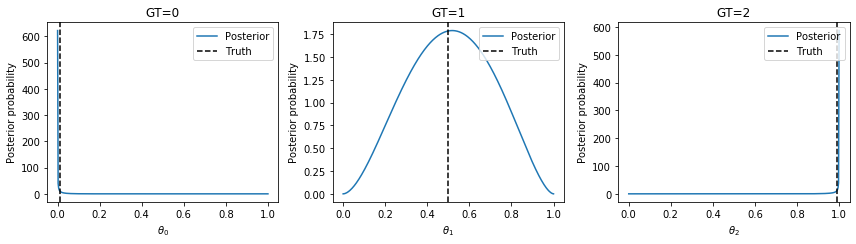

In [13]:
fig = plt.figure(figsize=(12, 3.5))
v = np.linspace(0.0001, 0.9999, 400)

for i in range(3):
    _md = tfd.Beta(tf.math.exp(model.beta_size[i,0]),
                   tf.math.exp(model.beta_size[i,1]))
    _pb = _md.prob(v)
    
    plt.subplot(1, 3, i+1)
    plt.plot(v, _pb, label="Posterior")
    plt.axvline(x=theta_true[i], linestyle='--', color='k', label="Truth")
    plt.title('GT=%d' %(i))
    plt.xlabel('$\\theta_%d$' %(i))
    plt.ylabel("Posterior probability")
    plt.legend(loc=1)

plt.tight_layout()
plt.show()

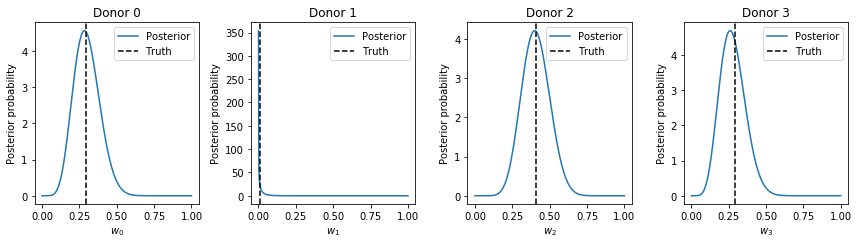

In [14]:
fig = plt.figure(figsize=(12, 3.5))
v = np.linspace(0.0001, 0.9999, 400)

for i in range(K):
    _md = tfd.Beta(tf.math.exp(model.w_size[i]),
                   tf.reduce_sum(tf.math.exp(model.w_size)) - tf.math.exp(model.w_size[i]))
    _pb = _md.prob(v)
    
    plt.subplot(1, K, i+1)
    plt.plot(v, _pb, label="Posterior")
    plt.axvline(x=w_true[i], linestyle='--', color='k', label="Truth")
    plt.title('Donor %d' %(i))
    plt.xlabel('$w_%d$' %(i))
    plt.ylabel("Posterior probability")
    plt.legend(loc=1)

plt.tight_layout()
plt.show()

### Model
The model is also included in: \
https://github.com/huangyh09/TensorFlow-Bayes/blob/master/TFBayes/GLM/binomial_regression.py

In [15]:
class BinomRegression():
    """
    d: number of theta categories
    K: number of components
    """
    def __init__(self, K, d=3, name=None):
        self.K = K
        self.d = d
        self.w_size = tf.Variable(tf.random.uniform([K], 0.3), name='w_size')
        self.beta_size = tf.Variable(tf.random.uniform([d, 2], 0.3), name='beta_size')
    
    @property
    def weight(self):
        """Variational posterior for the weight"""
        return tfd.Dirichlet(tf.math.exp(self.w_size))

    @property
    def ASR(self):
        """Variational posterior for the binomial rate"""
        return tfd.Beta(tf.math.exp(self.beta_size[:,0]), 
                        tf.math.exp(self.beta_size[:,1]))
    
    @property
    def losses(self):
        """Sum of KL divergences between posteriors and priors"""
        w_prior = tfd.Dirichlet(tf.ones([self.K]))
        theta_prior = tfd.Beta([0.1, 3, 9.9], [9.9, 3, 0.1])
        
        return (tf.reduce_sum(tfd.kl_divergence(self.weight, w_prior)) +
                tf.reduce_sum(tfd.kl_divergence(self.ASR, theta_prior)))
    
    def logLik(self, A, D, GT, sampling=False):
        """binomial coefficient needs to be added"""
        sample = lambda x: x.sample() if sampling else x.mean()
        _theta = tf.tensordot(tf.tensordot(GT, sample(self.ASR), axes=[[2], [0]]),
                              sample(self.weight), axes=[[1], [0]])
        
        _logLik = A * tf.math.log(_theta) + (D - A) * tf.math.log(1 - _theta)
        return _logLik
    
    def fit(self, A, D, GT, num_steps=100, optimizer=None,
            learn_rate=0.05):
        """Fit the model's parameters"""
        if optimizer is None:
            optimizer = tf.optimizers.Adam(learning_rate=learn_rate)
            
        loss_fn = lambda: (self.losses - tf.reduce_sum(self.logLik(A, D, GT)))
        
        losses = tfp.math.minimize(loss_fn, 
                                   num_steps=num_steps, 
                                   optimizer=optimizer)
        return losses
